### Approximating of image by SVD

In [8]:
from scipy import misc
img = misc.face()

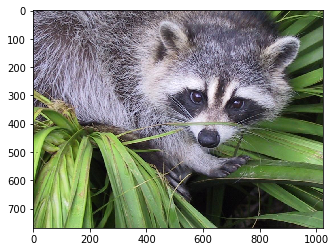

In [9]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [10]:
img.shape

(768, 1024, 3)

In [11]:
img_array = img / 255

In [12]:
red_array = img_array[:, :, 0]
green_array = img_array[:, :, 1]
blue_array = img_array[:, :, 2]

# Gray

Note that according to colorimetry, it is possible to obtain a fairly reasonable grayscale version of our color image if we apply the formula

Y = 0.2126 R + 0.7152 G + 0.0722 B
* https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-preserving)_conversion_to_grayscale

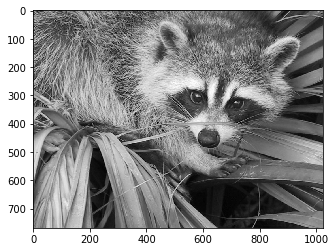

In [13]:
img_gray = img_array @ [0.2126, 0.7152, 0.0722]
plt.imshow(img_gray, cmap="gray")

In [14]:
from numpy import linalg
U, s, Vt = linalg.svd(img_gray)

In [15]:
U.shape, s.shape, Vt.shape

((768, 768), (768,), (1024, 1024))

### Approximation

In [16]:
import numpy as np
Sigma = np.zeros((768, 1024))
for i in range(768):
    Sigma[i, i] = s[i]

In [17]:
linalg.norm(img_gray - U @ Sigma @ Vt)

1.3247333627457426e-12

We could also have used the numpy.allclose function to make sure the reconstructed product is, in fact, close to our original matrix (the difference between the two arrays is small):

In [18]:
np.allclose(img_gray, U @ Sigma @ Vt)

True

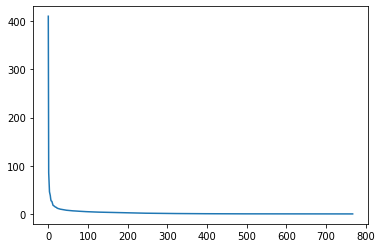

In [19]:
plt.plot(s)

In [20]:
k = 30
print(s[0:k])
print(s[-k:])

[410.42098224  85.56090199  63.61066707  45.85114695  41.96884158
  38.25875097  31.65941584  27.22637539  26.52061638  26.10815362
  23.42487722  21.49916197  17.85652873  17.37941645  16.86574464
  16.26735411  15.48694805  14.87815069  14.11500662  13.96559631
  13.70732297  12.75569782  12.12907909  11.97909232  11.38919277
  11.23491655  11.03374003  10.70472619  10.38856926  10.24748813]
[0.01602401 0.01581899 0.01554661 0.01532693 0.0151893  0.01509719
 0.01506942 0.01472172 0.01449441 0.0144448  0.01413233 0.01404597
 0.01384886 0.01363743 0.01353051 0.01329463 0.01295343 0.01278593
 0.01255073 0.01239892 0.01215173 0.01201027 0.01164519 0.01142034
 0.01127394 0.01117286 0.01085116 0.01079159 0.01031601 0.00992525]


In [21]:
approx = U @ Sigma[:, :k] @ Vt[:k, :]

6.503979308378181


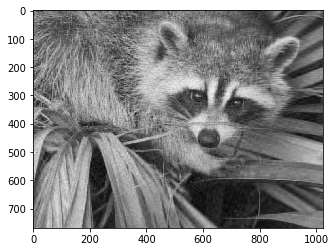

In [22]:
k = 60
print(s[k])
approx = U @ Sigma[:, :k] @ Vt[:k, :]
plt.imshow(approx, cmap="gray")

How the image looks like with the remaining singular Vectors

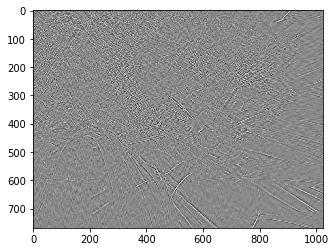

In [23]:
#print(s[k:768])
approx = U @ Sigma[:, k:768] @ Vt[k:768, :]
plt.imshow(approx, cmap="gray")

Not really informative

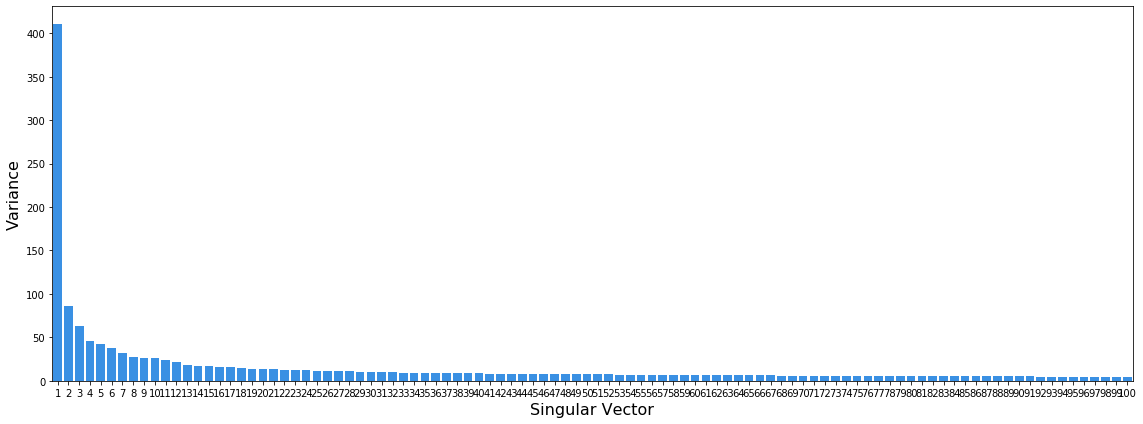

In [109]:
plt.figure(figsize=(16, 6))
import seaborn as sns
sns.barplot(x=list(range(1,k+1)), y=s[0:k], color="dodgerblue")
plt.xlabel('Singular Vector', fontsize=16)
plt.ylabel('Variance', fontsize=16)
plt.tight_layout()

### Applying to all colors

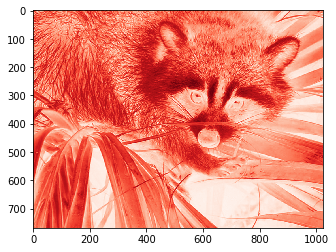

In [25]:
img_red = img_array @ [1, 0, 0]
plt.imshow(img_red, cmap="Reds")

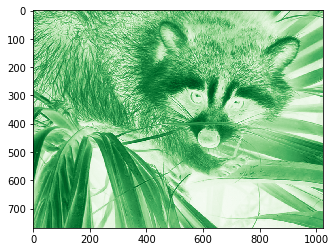

In [26]:
img_green = img_array @ [0, 1, 0]
plt.imshow(img_green, cmap="Greens")

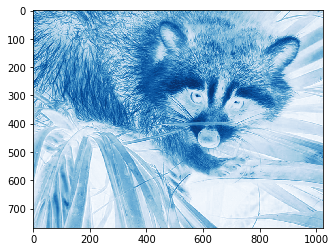

In [27]:
img_blue = img_array @ [0, 0, 1]
plt.imshow(img_blue, cmap="Blues")

In [28]:
def channel_svd(channel):
    [u, sigma, vt] = np.linalg.svd(channel)
    return [u, sigma, vt]

In [87]:
[u_red, s_red, vt_red] = channel_svd(img_red)
[u_blue, s_blue, vt_blue] = channel_svd(img_green)
[u_green, s_green, vt_green] = channel_svd(img_blue)

In [88]:
s_red_diagonalize = np.diag(s_red)
s_blue_diagonalize = np.diag(s_blue)
s_green_diagonalize = np.diag(s_green)

## Plot SV Variance for red channel

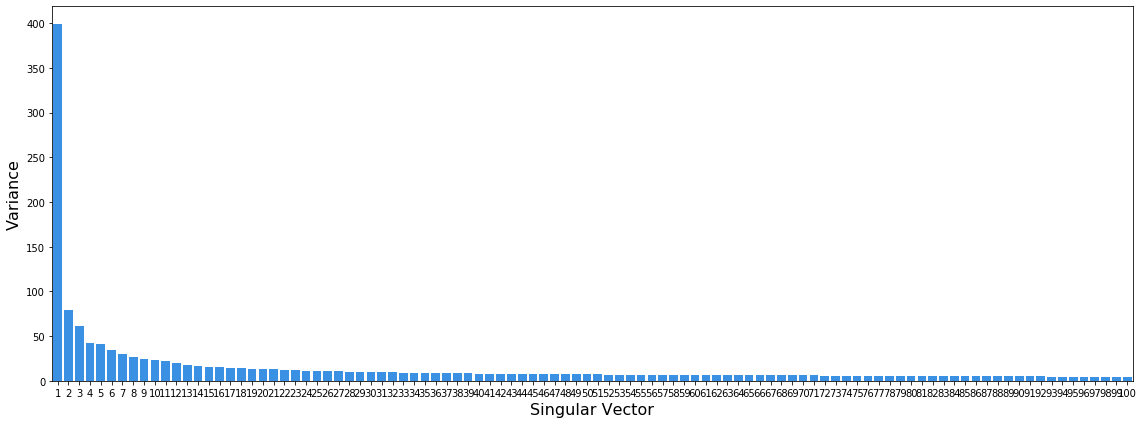

In [89]:
k=100
plt.figure(figsize=(16, 6))
import seaborn as sns
sns.barplot(x=list(range(1,k+1)), y=s_red[0:k], color="dodgerblue")
plt.xlabel('Singular Vector', fontsize=16)
plt.ylabel('Variance', fontsize=16)
plt.tight_layout()

### Choose optimal count of SV

In [95]:
def optimal_k(svectors_for_channel):
    for k in range(len(svectors_for_channel)-1):
        if (svectors_for_channel[k]-svectors_for_channel[k+1])**2<=0.0001:
            break
    
    return [k, svectors_for_channel[k]]

In [96]:
print(optimal_k(s_red))
print(optimal_k(s_green))
print(optimal_k(s_blue))

[69, 5.941500730678939]
[45, 7.410329343810054]
[78, 5.555287806878548]


# Lets choose for red channel k = 69, for green channel k = 45, for blue channel k = 78. 

In [98]:
optimal_k = int(np.median(np.asarray([optimal_k(s_red)[0], optimal_k(s_green)[0], optimal_k(s_blue)[0]])))
print(optimal_k)

69


In [102]:
def channel_via_optimal_k(k, u, s_diagonalized, vt):
    channel_u_k = u[:, :k]
    channel_s_diagonal_k = s_diagonalized[:k, :k]
    channel_vt_k = vt[:k, :]
    channel_reconstruction_matrix = np.dot(np.dot(channel_u_k, channel_s_diagonal_k), channel_vt_k)
    channel_reconstruction_matrix = 255 * channel_reconstruction_matrix
    return channel_reconstruction_matrix

In [103]:
blue_reconstruction_matrix = channel_via_optimal_k(optimal_k, u_blue, s_blue_diagonalize, vt_blue)
green_reconstruction_matrix = channel_via_optimal_k(optimal_k, u_green, s_green_diagonalize, vt_green)
red_reconstruction_matrix = channel_via_optimal_k(optimal_k, u_red, s_red_diagonalize, vt_red)

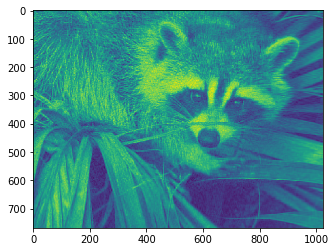

In [104]:
plt.imshow(blue_reconstruction_matrix)
plt.imshow(green_reconstruction_matrix)
plt.imshow(red_reconstruction_matrix)

### How the image looks like with the remaining singular Vectors

In [105]:
def channel_via_not_optimal_k(k, u, s_diagonalized, vt):
    channel_u_k = u[:, k:len(s_diagonalized)]
    channel_s_diagonal_k = s_diagonalized[k:len(s_diagonalized), k:len(s_diagonalized)]
    channel_vt_k = vt[k:len(s_diagonalized), :]
    channel_reconstruction_matrix = np.dot(np.dot(channel_u_k, channel_s_diagonal_k), channel_vt_k)
    channel_reconstruction_matrix = 255 * channel_reconstruction_matrix
    return channel_reconstruction_matrix

In [107]:
blue_reconstruction_matrix = channel_via_not_optimal_k(optimal_k, u_blue, s_blue_diagonalize, vt_blue)
green_reconstruction_matrix = channel_via_not_optimal_k(optimal_k, u_green, s_green_diagonalize, vt_green)
red_reconstruction_matrix = channel_via_not_optimal_k(optimal_k, u_red, s_red_diagonalize, vt_red)

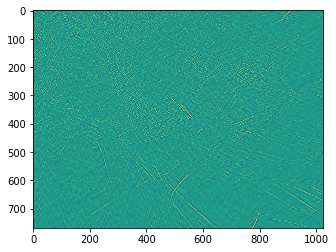

In [108]:
plt.imshow(blue_reconstruction_matrix)
plt.imshow(green_reconstruction_matrix)
plt.imshow(red_reconstruction_matrix)

# Conclusion 
Singular value decomposition has applications in image compression. Using SVD we resolve problems with storiging and transmiting images and also processing (using in ML algorithms). In simple words we delete insignificant data from image and make work with them easer.

Working with SVD we need to be carefull and use(find) methods to find optimal count of significant singular values. We need find balance between count of sv and image quality (for our needs).



The advantage of using the SVD is the property of energy compaction and its ability to adapt to the local statistical variations of an image. Further, the SVD can be performed on any arbitrary, square, reversible and non reversible matrix of m x n size